## Investigating further into Thalamus 

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange
import seaborn as sns
from utils import get_logs_and_files, convert_train_to_test_idx


In [2]:
# exp_name= 'neurips'
data_folder = './../files/paper_data/'
exp_name= 'ReasonableThalanetExample/'
# data_folder = './../files/cluster/'
# exp_name= ''
# exp_name= 'neurips/brittle_policy'
# exp_name= 'neurips/td'
data_folder = './../files/paper_data/cluster_paradigm_long/'
exp_name= 'random_gates_mul'
print('current folder: ', os.getcwd())
filenames = os.listdir(data_folder + exp_name)
testing_log_files = [logfile for logfile in filenames if logfile.__contains__('testing_log')]
training_log_files = [logfile for logfile in filenames if logfile.__contains__('training_log')]
config_files = [logfile for logfile in filenames if logfile.__contains__('config')]
# print('config files: ', config_files)
# print('testing_logs :', testing_log_files)
# print('training_logs :', training_log_files)

current folder:  /home/ahummos/code/multiplicative/analysis


In [3]:
seed = 1
loops = 1000.0
task_rule = 1.0
no_of_tasks = 10
var4  = 1.0

# data_folder = './../files/cluster_2/'
# exp_name= ''
# seed = 11
# task_rule = 4.0
# no_of_tasks = 3
def load_simulation(data_folder, exp_name, seed, loops, task_rule, var4, no_of_tasks):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_{loops:3.1f}_{task_rule:1.1f}_{var4:1.1f}']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log

# data_folder = './../files/cluster_2/'
# exp_name= ''
# seed = 11
# task_rule = 4.0
# no_of_tasks = 3
config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, loops, task_rule, var4, no_of_tasks)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


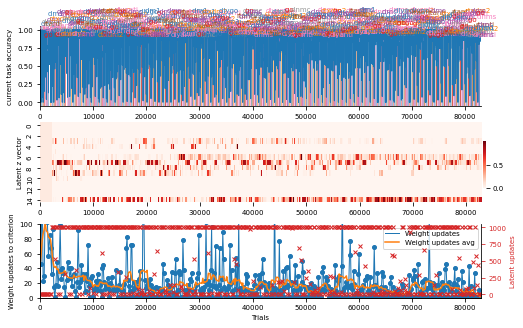

In [4]:
def plot_long_term_cluster_discovery( config, training_log, testing_log):
    # if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    if len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    elif len(training_log.md_context_ids) > 0: context_ids =  training_log.md_context_ids
    else: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]


    x0, x1 = 0, training_log.stamps[-1]
    no_of_values = len(config.tasks)
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 

    fig, axes = plt.subplots(3,1, figsize=[20/2.53,5], sharex = False)

    ax = axes[0]
    # ax.set_position(mpl.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))
    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1], linewidth=1)
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=7)
    ax.set_ylabel('current task accuracy')
    ax.set_xlim([x0, x1])
    # print('axis 0 position: ',ax.get_position())
    
    ax = axes[1] # context ids
    md = np.stack([m[0] for m in context_ids])
    # print(fig.get_axes())
    im = sns.heatmap(md.T, cmap='Reds', ax = ax)#, vmax=md.max()/3)
    # print(fig.get_axes())
    # print('colorbar pos:', fig.get_axes()[-1].get_position())
    fig.get_axes()[-1].set_position(mpl.transforms.Bbox([[0.9037,0.39],[.90785, 0.600]]))
    # ax.get_shared_x_axes().join(ax, axes[0])
    ax.set_xticks(axes[0].get_xticks()[:-1])
    ax.set_xticklabels(axes[0].get_xticklabels()[:-1], rotation=0)
    # ax.set_xlabel('Batches (100 trials)')
    ax.set_ylabel('Latent z vector')
    ax.set_position(mpl.transforms.Bbox([[0.125,0.39],[.902, 0.613]]))
    # ax.set_position(mpl.transforms.Bbox([[0.125,0.52],[.99, 0.683]]))
    # print(ax.get_position())

    ax = axes[2] # mean_bu
    # ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    # ax.set_xlim([x0, x1])
    # ax.set_ylabel('current task accuracy')
    # ax.set_xlabel('Batches (100 trials)')
    # # print(ax.get_position())
    # # =0.125, y0=0.32195652173913036, x1=0.9, y1=0.4860869565217391
    # ax.set_position(mpl.transforms.Bbox([[0.125,0.32],[.9, 0.45]]))
    # ax.plot(training_log.trials_to_crit, label = 'trials to crit')
    ax.plot(training_log.switch_trialxxbatch, training_log.trials_to_crit, label = 'Weight updates', color='tab:blue', linewidth=1)
    ax.plot(training_log.switch_trialxxbatch,training_log.trials_to_crit, 'o', markersize=4, color='tab:blue')
    filter=10
    filtered_mean = np.convolve(np.array(training_log.trials_to_crit), np.ones(filter)/filter, 'same')
    ax.plot(training_log.switch_trialxxbatch,filtered_mean, label=f'Weight updates avg', color='tab:orange',)
    try:
        mpl.rcParams['axes.spines.right'] = True
        ax2 =  ax.twinx()
        ax2.set_ylabel('Latent updates', color= 'tab:red') 
        ax2.plot(training_log.switch_trialxxbatch,np.clip(np.array(training_log.latents_to_crit),0, a_max=1000), 'x',markersize=4,color='tab:red', label = 'Latent updates')
        ax2.tick_params(axis='y', color='tab:red', labelcolor='tab:red')
        mpl.rcParams['axes.spines.right'] = False
    except:
        pass
    ax.set_ylabel('Weight updates to criterion')
    ax.set_xlabel('Trials')
    ax.set_xlim([x0, x1])
    ax.set_ylim(0, 100)#filtered_mean.max()*1.5)
    if hasattr(training_log, 'converged_detected_at'):
        ax.axvline(training_log.converged_detected_at, color='tab:green', alpha=0.5, linewidth=2, label='Converged')
    ax.legend()
    # print(ax.get_position())
    ax.set_position(mpl.transforms.Bbox([[0.125,0.125],[.90, 0.33]]))
    # plt.savefig(f'./files/to_examine/5/thalanet_{seed}_{no_of_tasks}.jpg', dpi=300)
plot_long_term_cluster_discovery(config, training_log, testing_log)

##### Mock convergence detction

/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


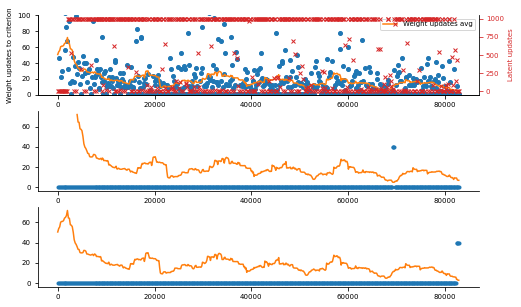

In [6]:
filter=10
filtered_mean = np.convolve(np.array(training_log.trials_to_crit), np.ones(filter)/filter, 'same')
fig, axes = plt.subplots(3,1, figsize=[20/2.53,5], sharex = False)

ax = axes[0]
# ax.plot(training_log.switch_trialxxbatch, training_log.trials_to_crit, label = 'Weight updates', color='tab:blue', linewidth=1)
ax.plot(training_log.switch_trialxxbatch,training_log.trials_to_crit, 'o', markersize=4, color='tab:blue')
filter=20
filtered_mean = np.convolve(np.array(training_log.trials_to_crit), np.ones(filter)/filter, 'same')

avg_ttcs = [np.mean(training_log.trials_to_crit[s-filter:s]) for s in range(len(training_log.trials_to_crit)) ]
ax.plot(training_log.switch_trialxxbatch,filtered_mean, label=f'Weight updates avg', color='tab:orange',)
try:
    mpl.rcParams['axes.spines.right'] = True
    ax2 =  ax.twinx()
    ax2.set_ylabel('Latent updates', color= 'tab:red') 
    ax2.plot(training_log.switch_trialxxbatch,np.clip(np.array(training_log.latents_to_crit),0, a_max=1000), 'x',markersize=4,color='tab:red', label = 'Latent updates')
    ax2.tick_params(axis='y', color='tab:red', labelcolor='tab:red')
    mpl.rcParams['axes.spines.right'] = False
except:
    pass
ax.set_ylabel('Weight updates to criterion')
ax.set_xlabel('Trials')
# ax.set_xlim([x0, x1])
ax.set_ylim(0, 100)#filtered_mean.max()*1.5)
ax.legend()

ax = axes[1]
ax.plot(training_log.switch_trialxxbatch,avg_ttcs, label=f'Weight updates avg', color='tab:orange',)
ax.plot(training_log.switch_trialxxbatch,(np.array(avg_ttcs)<5) * 40, '.', markersize=6)
ax = axes[2]
ax.plot(training_log.switch_trialxxbatch,filtered_mean, label=f'Weight updates avg', color='tab:orange',)
ax.plot(training_log.switch_trialxxbatch,(filtered_mean<4) *40, '.', markersize=6)


### Representational drift?

In [7]:
idx = 15000
print(training_log.md_context_ids[idx])
print(training_log.task_ids[idx+60:idx+110])

[[9.8101448e-23 2.2447081e-22 1.4930750e-22 3.6025172e-06 3.8169887e-02
  6.4260039e-21 4.1538692e-04 2.9376614e-01 1.3599157e-01 5.2346909e-01
  1.1793994e-15 8.4794539e-23 8.2395057e-23 3.2950875e-23 8.1842691e-03]]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [8]:
solved_idx=(np.array(training_log.trials_to_crit[1:]) !=99) # tasks that wehere actually solved
print(f'solved tasks ratio {np.sum(solved_idx)/solved_idx.size:2.1f}')

solved tasks ratio 1.0


In [9]:
md_context_ids = np.stack([m.mean(0) for m in training_log.md_context_ids])
task_ids = np.stack(training_log.task_ids)
N = md_context_ids.shape[0]
discard = int(N* .2)
md_context_ids = md_context_ids[discard:]
task_ids = task_ids[discard:]
N = md_context_ids.shape[0]

print(f'shape of md context ids: {md_context_ids.shape}')
print(f'shape of task id: {task_ids.shape}')



shape of md context ids: (66400, 15)
shape of task id: (66400,)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.datasets import make_classification
# tune regularization for multinomial logistic regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

no_of_points = 20000
early_start= 0
early_end = early_start + no_of_points
late_start = N-no_of_points
late_end = late_start + no_of_points

X_early = md_context_ids[early_start:early_end]
y_early = task_ids[early_start: early_end]
X_late = md_context_ids[late_start:late_end]
y_late = task_ids[late_start: late_end]
# summarize the dataset
print(X_early.shape, y_early.shape)
print(Counter(y_early))

model_early = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model_early.fit(X_early, y_early)
model_late = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model_late.fit(X_late, y_late)
# yhat_early = model.predict(X_early)
# plt.plot(yhat)
# plt.plot(y)
# print('accuracy', np.mean(yhat==y))

(20000, 15) (20000,)
Counter({3: 2100, 8: 2100, 5: 2050, 12: 2050, 2: 1950, 14: 1950, 10: 1950, 0: 1950, 13: 1950, 6: 1950})


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [11]:
# maxxx = 83,000
accuracies_early = []
accuracies_late = []
sample_every = 100
sample_length = 10000
test_points = list(range(0, N-sample_length, sample_every))

for test_i in test_points:
    X = md_context_ids[test_i:test_i+sample_length]
    y = task_ids[test_i:test_i+sample_length]
    yhat = model_early.predict(X)
    accuracies_early.append(np.mean(yhat==y))
    yhat = model_late.predict(X)
    accuracies_late.append(np.mean(yhat==y))


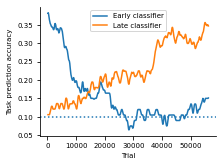

In [12]:
fig, ax = plt.subplots(1,1, figsize=[8/2.53, 6/2.53])
accuracies = accuracies_early
accuracies = np.convolve(np.stack(accuracies), np.ones(5)/5, 'valid')
ax.plot(test_points[2:-2], accuracies, label= 'Early classifier')
accuracies = accuracies_late
accuracies = np.convolve(np.stack(accuracies), np.ones(5)/5, 'valid')
ax.plot(test_points[2:-2], accuracies, label= 'Late classifier')
ax.axhline(0.1, linestyle=':')
ax.set_xlabel('Trial')
ax.set_ylabel('Task prediction accuracy')
ax.legend()
# plt.savefig('./files/pdfs/representational_drift.pdf', dpi=300)


In [15]:
print(task_ids.shape)
print(test_i)
print(test_i+sample_every)


(66400,)
56300
56400


In [22]:
seed = 3
loops = 1.0
task_rule = 100.0
no_of_tasks = 10
var4  = 100.0

data_folder = './../files/iclr_neurogym_tsne_no_WU_after_convergence/'
exp_name= 'few_shot_testing'
def load_simulation(data_folder, exp_name, seed, loops, task_rule, var4, no_of_tasks):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_neurogym{loops:3.1f}_{task_rule:1.1f}_{var4:1.1f}']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log

config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, loops, task_rule, var4, no_of_tasks)

In [23]:
training_log.converged_detected_at

25000

In [32]:
end_of_blocks  = np.array(training_log.switch_trialxxbatch)

md_context_ids = np.stack([m.mean(0) for m in training_log.md_context_ids])
task_ids = np.stack(training_log.task_ids)
N = md_context_ids.shape[0]
discard = training_log.converged_detected_at #training_log.convergence#int(N* .4)
end_of_blocks = end_of_blocks[end_of_blocks>discard]
md_context_ids = md_context_ids[end_of_blocks]
task_ids = task_ids[end_of_blocks]
N = md_context_ids.shape[0]

print(f'shape of md context ids: {md_context_ids.shape}')
print(f'shape of task id: {task_ids.shape}')

shape of md context ids: (159, 15)
shape of task id: (159,)


using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/159 [00:00<?, ?it/s]

fitting...


  0%|          | 0/1000 [00:00<?, ?it/s]

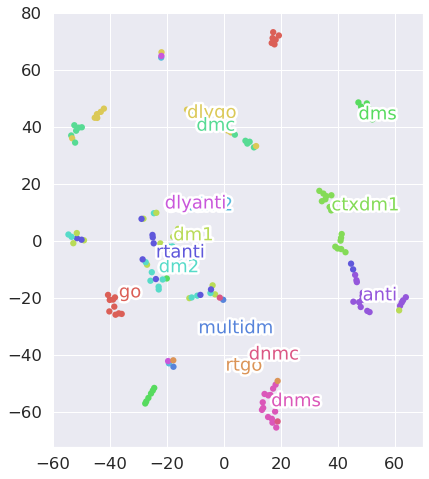

In [37]:
import matplotlib.patheffects as PathEffects
%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
from tsne_torch import TorchTSNE as TSNE
skipped = 0
X = md_context_ids[skipped:]  # shape (n_samples, d)
colors = task_ids[skipped:]
X_emb = TSNE(n_components=2, perplexity=3, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)
x= X_emb 

num_classes = X.shape[1]
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])

# add the labels for each digit corresponding to the label
txts = []


for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config.human_task_names[i], color = palette[i], fontsize=18)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)
plt.savefig('./files/pdfs/Thalamus_tsne.pdf', dpi=300)